<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare against published iModulons</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
from pymodulon.compare import *
from pymodulon.io import *

In [5]:
# Enter the location of your data here
ica_data_dir = '../data/interim/ica_runs/220'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [22]:
df_metadata = pd.read_csv('../data/interim/metadata_qc.csv',index_col=0)
df_metadata[['project_name','condition_name','rep_name','reference_condition','DOI']].head()

,project_name,condition_name,rep_name,reference_condition,DOI
CJ522_f_1,Muconate,CJ522_fructose,1.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_f_2,Muconate,CJ522_fructose,2.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_f_3,Muconate,CJ522_fructose,3.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_fg_1,Muconate,CJ522_fructose_glucose,1.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_fg_2,Muconate,CJ522_fructose_glucose,2.0,KT2440_glucose,10.1016/j.ymben.2020.01.001


In [23]:
df_metadata=df_metadata.rename(columns={'project_name':'project',
    'condition_name':'condition'})

In [24]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


In [25]:
df_metadata.to_csv('../data/raw_data/sample_table.csv')

## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [13]:
df_trn = pd.read_csv('../data/external/TRN_update_210616.csv')
df_trn.head()

,regulator,regulator_id,gene_id,gene_name,Pputida,evidence
0,Zur,PP_0119,PP_0117,znuB,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
1,Zur,PP_0119,PP_0118,znuC,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
2,Zur,PP_0119,PP_0119,zur,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
3,Zur,PP_0119,PP_0120,znuA,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
4,Zur,PP_0119,PP_0506,PP_0506,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."


The `regulator` and `gene_id` must be filled in for each row

In [14]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [17]:
ica_data_dir

'../data/interim/ica_runs/220'

In [20]:
#ensure every columns are sorted

A=pd.read_csv(path.join(ica_data_dir,'A.csv'),index_col=0)
X=pd.read_csv('../data/processed_data/log_tpm_norm.csv',index_col=0)
set(X.columns)-set(A.columns)
A[X.columns].to_csv(path.join(ica_data_dir,'A.csv'))

In [21]:
X_log_tpm=pd.read_csv('../data/interim/log_tpm_qc.csv',index_col=0)
set(X.columns)-set(X_log_tpm.columns)
X_log_tpm[X.columns].to_csv('../data/interim/log_tpm_qc.csv')

In [42]:
#M matrix renamed as S matrix

ica_data = IcaData(M = path.join(ica_data_dir,'S.csv'),
                   A = path.join(ica_data_dir,'A.csv'),
                   X = '../data/processed_data/log_tpm_norm.csv',
                   log_tpm = '../data/interim/log_tpm_qc.csv',
                   gene_table = '../data/processed_data/gene_info.csv',
                   sample_table = '../data/raw_data/sample_table.csv',
                   trn = df_trn)

In [45]:
#update gene names

ica_data.gene_table.loc['PP_2665', 'gene_name'] = 'pedR1'
ica_data.gene_table.loc['PP_4283', 'gene_name'] = 'gclR'
ica_data.gene_table.loc['PP_0119', 'gene_name'] = 'zur'
ica_data.gene_table.loc['PP_4734', 'gene_name'] = 'lldR'
ica_data.gene_table.loc['PP_5292', 'gene_name'] = 'crc'
ica_data.gene_table.loc['PP_3738', 'gene_name'] = 'vanR'
ica_data.gene_table.loc['PP_3740', 'gene_name'] = 'vanK'
ica_data.gene_table.loc['PP_3415', 'gene_name'] = 'gnuR'
ica_data.gene_table.loc['PP_4039', 'gene_name'] = 'pydR'
ica_data.gene_table.loc['PP_4371', 'gene_name'] = 'fleR'
ica_data.gene_table.loc['PP_0740', 'gene_name'] = 'pplR1'
ica_data.gene_table.loc['PP_1366', 'gene_name'] = 'turA'
ica_data.gene_table.loc['PP_3765', 'gene_name'] = 'turB'
ica_data.gene_table.loc['PP_4470', 'gene_name'] = 'amrZ'
ica_data.gene_table.loc['PP_1637', 'gene_name'] = 'finR'
ica_data.gene_table.loc['PP_2144', 'gene_name'] = 'psrA'
ica_data.gene_table.loc['PP_0792', 'gene_name'] = 'fruR'
ica_data.gene_table.loc['PP_0997', 'gene_name'] = 'gcsR'
ica_data.gene_table.loc['PP_3539', 'gene_name'] = 'liuR'
ica_data.gene_table.loc['PP_5140', 'gene_name'] = 'cadR'
ica_data.gene_table.loc['PP_0594', 'gene_name'] = 'rutR-I'

ica_data.gene_table.loc['PP_3088', 'gene_name'] = 'tssA1'
ica_data.gene_table.loc['PP_3089', 'gene_name'] = 'hcp1'
ica_data.gene_table.loc['PP_3090', 'gene_name'] = 'tagP1'
ica_data.gene_table.loc['PP_5561', 'gene_name'] = 'tagF1'
ica_data.gene_table.loc['PP_3091', 'gene_name'] = 'tssM1'
ica_data.gene_table.loc['PP_3092', 'gene_name'] = 'tssL1'
ica_data.gene_table.loc['PP_3093', 'gene_name'] = 'tssK1'
ica_data.gene_table.loc['PP_3094', 'gene_name'] = 'tssJ1'
ica_data.gene_table.loc['PP_3096', 'gene_name'] = 'tssG1'
ica_data.gene_table.loc['PP_3097', 'gene_name'] = 'tssF1'
ica_data.gene_table.loc['PP_3098', 'gene_name'] = 'tssE1'
ica_data.gene_table.loc['PP_3100', 'gene_name'] = 'tssB1'
ica_data.gene_table.loc['PP_5562', 'gene_name'] = 'tagX1'


  0%|          | 0/39 [00:00<?, ?it/s]

1350

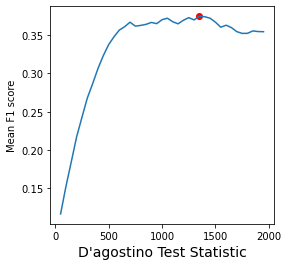

In [46]:
ica_data.reoptimize_thresholds()

In [47]:
from pymodulon.util import explained_variance

In [48]:
ica_data

In [49]:
explained_variance(ica_data)

0.757486348792913

In [50]:
ica_data.thresholds

{0: 0.1465899707926441,
 1: 0.06576868642961345,
 2: 0.1343846904961519,
 3: 0.0580509977169459,
 4: 0.20294031144286145,
 5: 0.11250819236310515,
 6: 0.3175092980296226,
 7: 0.1112031005491959,
 8: 0.0894212445434258,
 9: 0.05262205469706085,
 10: 0.1363223569780601,
 11: 0.10890943103717485,
 12: 0.08799978363480065,
 13: 0.0851790442821364,
 14: 0.0590949092418735,
 15: 0.0773866330440013,
 16: 0.1040955942946375,
 17: 0.11185539771305475,
 18: 0.13511588508628403,
 19: 0.037969861255464546,
 20: 0.0678197440565822,
 21: 0.18787439564987995,
 22: 0.1258513712600044,
 23: 0.06907740669955766,
 24: 0.08399320742121905,
 25: 0.08934066653349605,
 26: 0.09546410542998525,
 27: 0.12821891758582343,
 28: 0.11233896519864078,
 29: 0.3115794939818317,
 30: 0.0846668037289168,
 31: 0.06721882821361169,
 32: 0.083812692993948,
 33: 0.1632007461961941,
 34: 0.1229063183531869,
 35: 0.10754345468280094,
 36: 0.0790826614204359,
 37: 0.060891064926091004,
 38: 0.07280338944588455,
 39: 0.0884165

# Manually changing threshold 

In [51]:
ica_data.change_threshold(39,0.08) # to include genes in the same regulon, original value: 0.08841650883937846
ica_data.change_threshold(66,0.132) # to include genes in the same regulon, original value: 0.08841650883937846

ica_data.change_threshold(68,0.053) # to include genes in the same TUs, original value: 0.0864759105949802
ica_data.change_threshold(72,0.140) # to include genes in the same TUs, original value: 0.14520632726624155
ica_data.change_threshold(73,0.11) # to include genes in the same regulon, original value: 0.13740759854641915
ica_data.change_threshold(74,0.11) # to include adjacent genes, original value: 0.14124960256879476




# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [53]:
ica_data.compute_trn_enrichment(save=True,fdr=.0001)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,1,GbdR,1.691643e-31,1.353314e-30,0.472222,0.548387,0.507463,17.0,31.0,36.0,1.0
1,1,RoxR,7.899450e-18,3.159780e-17,0.361111,0.224138,0.276596,13.0,58.0,36.0,1.0
2,4,PedR1,3.624905e-05,7.249811e-05,1.000000,0.058824,0.111111,2.0,34.0,2.0,1.0
3,12,GclR,1.182626e-23,8.278380e-23,0.714286,0.526316,0.606061,10.0,19.0,14.0,1.0
4,12,RutR-I,9.452290e-13,3.308301e-12,0.357143,0.714286,0.476190,5.0,7.0,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57,71,Fur,6.829839e-23,3.756412e-22,0.416667,0.306122,0.352941,15.0,49.0,36.0,1.0
58,73,GcsR,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,4.0,4.0,4.0,1.0
59,76,LiuR,4.328164e-10,3.895347e-09,0.333333,0.571429,0.421053,4.0,7.0,12.0,1.0
60,78,HmgR,2.325027e-06,2.325027e-06,0.500000,0.500000,0.500000,2.0,4.0,4.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [54]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
1,GbdR,1.691643e-31,1.353314e-30,0.472222,0.548387,0.507463,17.0,31.0,36.0,1.0
4,PedR1,3.624905e-05,7.249811e-05,1.000000,0.058824,0.111111,2.0,34.0,2.0,1.0
12,GclR,1.182626e-23,8.278380e-23,0.714286,0.526316,0.606061,10.0,19.0,14.0,1.0
13,FnrA,3.175401e-06,2.222781e-05,0.187500,0.272727,0.222222,3.0,11.0,16.0,1.0
19,Zur,9.059640e-41,4.529820e-40,0.515152,1.000000,0.680000,17.0,17.0,33.0,1.0
21,LldR,5.575521e-10,1.115104e-09,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0
22,VanR,1.394068e-10,4.182205e-10,0.750000,1.000000,0.857143,3.0,3.0,4.0,1.0
24,ColR,9.406767e-07,3.762707e-06,0.272727,0.272727,0.272727,3.0,11.0,11.0,1.0
27,BenR,5.264419e-12,2.632210e-11,0.400000,1.000000,0.571429,4.0,4.0,10.0,1.0
28,PtxS,7.279373e-24,1.455875e-23,0.727273,1.000000,0.842105,8.0,8.0,11.0,1.0


In [55]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:5])

[0, 'GbdR', 2, 3, 'PedR1-1']


# Functional iModulons

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [57]:
DF_KEGG = pd.read_csv('../data/sequence_files/kegg_mapping.csv',index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2485,PP_0006,KEGG_pathway,map02024
2486,PP_0006,KEGG_pathway,map03060
2487,PP_0006,KEGG_pathway,map03070
2490,PP_0010,KEGG_pathway,map02020
2491,PP_0010,KEGG_pathway,map04112


In [58]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [59]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [60]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,GbdR,map00260,2.103570e-07,0.000046,0.166667,0.142857,0.153846,6.0,42.0,36.0
1,GbdR,map00680,2.706639e-05,0.002991,0.111111,0.142857,0.125000,4.0,28.0,36.0
2,GbdR,map01100,8.164246e-04,0.060143,0.333333,0.017544,0.033333,12.0,684.0,36.0
3,7,map00010,2.018263e-05,0.002230,0.300000,0.093750,0.142857,3.0,32.0,10.0
4,7,map00030,1.338087e-05,0.002230,0.300000,0.107143,0.157895,3.0,28.0,10.0


In [61]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,GbdR,M00208,4.910679e-06,0.001404,0.083333,0.500000,0.142857,3.0,6.0,36.0
1,7,M00001,9.122944e-07,0.000261,0.300000,0.250000,0.272727,3.0,12.0,10.0
2,7,M00114,4.344812e-05,0.006213,0.200000,0.333333,0.250000,2.0,6.0,10.0
3,7,M00004,1.900744e-04,0.018120,0.200000,0.166667,0.181818,2.0,12.0,10.0
4,9,M00009,1.414946e-06,0.000405,0.090909,0.238095,0.131579,5.0,21.0,55.0


### Convert KEGG IDs to human-readable names

In [62]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [63]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,GbdR,map00260,2.103570e-07,0.000046,0.166667,0.142857,0.153846,6.0,42.0,36.0,"Glycine, serine and threonine metabolism"
1,GbdR,map00680,2.706639e-05,0.002991,0.111111,0.142857,0.125000,4.0,28.0,36.0,Methane metabolism
2,GbdR,map01100,8.164246e-04,0.060143,0.333333,0.017544,0.033333,12.0,684.0,36.0,Metabolic pathways
3,7,map00010,2.018263e-05,0.002230,0.300000,0.093750,0.142857,3.0,32.0,10.0,Glycolysis / Gluconeogenesis
4,7,map00030,1.338087e-05,0.002230,0.300000,0.107143,0.157895,3.0,28.0,10.0,Pentose phosphate pathway


In [64]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,GbdR,M00208,4.910679e-06,0.001404,0.083333,0.500000,0.142857,3.0,6.0,36.0,NaN
1,7,M00001,9.122944e-07,0.000261,0.300000,0.250000,0.272727,3.0,12.0,10.0,"Glycolysis (Embden-Meyerhof pathway), glucose ..."
2,7,M00114,4.344812e-05,0.006213,0.200000,0.333333,0.250000,2.0,6.0,10.0,"Ascorbate biosynthesis, plants, fructose-6P =>..."
3,7,M00004,1.900744e-04,0.018120,0.200000,0.166667,0.181818,2.0,12.0,10.0,Pentose phosphate pathway (Pentose phosphate c...
4,9,M00009,1.414946e-06,0.000405,0.090909,0.238095,0.131579,5.0,21.0,55.0,"Citrate cycle (TCA cycle, Krebs cycle)"


### Save files

In [65]:
DF_pathway_enrich.to_csv('../data/processed_data/kegg_pathway_enrichments.csv')
DF_pathway_enrich.to_csv('../data/processed_data/kegg_module_enrichments.csv')

# Check for single gene iModulons

In [66]:
sg_imods = ica_data.find_single_gene_imodulons()
sg_imods

[6, 29, 50, 63, 66, 75, 82]

In [67]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [68]:
sg_imods

[6, 29, 50, 63, 66, 75, 82]

In [69]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [70]:
ica_data.imodulon_names[:10]

[0, 'GbdR', 2, 3, 'PedR1-1', 5, 'single_gene_1', 7, 8, 9]

In [73]:
ica_data.imodulon_names

['Null-1',
 'GbdR',
 'PP_2034-7',
 'Multiple stress-1',
 'PedR1-1',
 'Acetate stress',
 'Noise-1',
 'Genomic-1',
 'Zinc',
 'TCA cycle',
 'Redox',
 'Pentose and glucuronate',
 'GclR',
 'FnrA-1',
 'Osmotic stress-1',
 'Phage-1',
 'Multiple stress-2',
 'Putrescine',
 'Uncharacterized-1',
 'Zur',
 'Uncharacterized-2',
 'LldR',
 'VanR',
 'Osmotic stress-2',
 'ColR',
 'Uncharacterized-3',
 'Exporters',
 'BenR',
 'PtxS',
 'Noise-2',
 'PvdS',
 'BkdR',
 'GltR-II',
 'Uncharacterized-4',
 'Null-2',
 'T6SS',
 'InfA',
 'PydR',
 'FliA',
 'PplR1',
 'Citrate',
 'Uncharacterized-5',
 'Uncharacterized-6',
 'AcoR',
 'TurA-1',
 'Genomic-2',
 'HutC',
 'Uncharacterized-7',
 'Metr-I',
 'AmrZ',
 'Noise-3',
 'Phage-2',
 'HexR',
 'Acetate',
 'RbsR',
 'Translation',
 'PP_5350',
 'PedR1-2',
 'PP_0204',
 'IonicLiquid',
 'GlnG',
 'Uncharacterized-8',
 'OxyR',
 'Noise-4',
 'PsrA',
 'PcaR',
 'Sulfur',
 'TurA-2',
 'FleQ-1',
 'FnrA-2',
 'FruR',
 'FleQ-2',
 'PP_2260-3',
 'GcsR',
 'PP_0615-8',
 'Noise-5',
 'LiuR',
 'Unch

# Manual curation

In [72]:
#iModulons do not have significant overlaps with known regulons were manually curated. Please see the manuscript for details.

ica_data.rename_imodulons({0:'Null-1'})

ica_data.rename_imodulons({2:'PP_2034-7'})
ica_data.rename_imodulons({3:'Multiple stress-1'})

ica_data.rename_imodulons({5:'Acetate stress'})
ica_data.rename_imodulons({'single_gene_1':'Noise-1'})
ica_data.rename_imodulons({7:'Genomic-1'})
ica_data.rename_imodulons({8:'Zinc'})
ica_data.rename_imodulons({9:'TCA cycle'})
ica_data.rename_imodulons({10:'Redox'})
ica_data.rename_imodulons({11:'Pentose and glucuronate'})


ica_data.rename_imodulons({14:'Osmotic stress-1'})
ica_data.rename_imodulons({15:'Phage-1'})
ica_data.rename_imodulons({16:'Multiple stress-2'})
ica_data.rename_imodulons({17:'Putrescine'})
ica_data.rename_imodulons({18:'Uncharacterized-1'})

ica_data.rename_imodulons({20:'Uncharacterized-2'})


ica_data.rename_imodulons({23:'Osmotic stress-2'})

ica_data.rename_imodulons({25:'Uncharacterized-3'})
ica_data.rename_imodulons({26:'Exporters'})


ica_data.rename_imodulons({'single_gene_2':'Noise-2'})



ica_data.rename_imodulons({33:'Uncharacterized-4'})
ica_data.rename_imodulons({34:'Null-2'})
ica_data.rename_imodulons({35:'T6SS'})
ica_data.rename_imodulons({36:'InfA'})



ica_data.rename_imodulons({40:'Citrate'})
ica_data.rename_imodulons({41:'Uncharacterized-5'})
ica_data.rename_imodulons({42:'Uncharacterized-6'})


ica_data.rename_imodulons({45:'Genomic-2'})

ica_data.rename_imodulons({47:'Uncharacterized-7'})


ica_data.rename_imodulons({'single_gene_3':'Noise-3'})
ica_data.rename_imodulons({51:'Phage-2'})

ica_data.rename_imodulons({53:'Acetate'})

ica_data.rename_imodulons({55:'Translation'})



ica_data.rename_imodulons({59:'IonicLiquid'})

ica_data.rename_imodulons({61:'Uncharacterized-8'})

ica_data.rename_imodulons({'single_gene_4':'Noise-4'})


ica_data.rename_imodulons({'single_gene_5':'Sulfur'})


ica_data.rename_imodulons({72:'PP_2260-3'})

ica_data.rename_imodulons({74:'PP_0615-8'})
ica_data.rename_imodulons({'single_gene_6':'Noise-5'})

ica_data.rename_imodulons({77:'Uncharacterized-9'})

ica_data.rename_imodulons({79:'Null-3'})

ica_data.rename_imodulons({81:'AA transport'})
ica_data.rename_imodulons({'single_gene_7':'Genomic-3'})
ica_data.rename_imodulons({83:'Noise-6'})



# Adding size information to the iModulon table

In [74]:
for i in ica_data.imodulon_table.index:
    ica_data.imodulon_table.loc[i,'imodulon_size']=len(ica_data.view_imodulon(i).index)
    ica_data.imodulon_table.loc[i,'TU_size']=len(ica_data.view_imodulon(i).operon.unique())

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [76]:
save_to_json(ica_data,'../Pputida_precise1.json')

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

# E. coli Precise 1 comparison

In [68]:
ecoli_data = load_json_model('../example_data/example.json')

In [69]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.2,
                         ortho_file = '../example_data/eColi_full_protein_vs_pPutida_full_protein_parsed.csv')
dots

[('OxyR', 'OxyR', 0.2780071660083247),
 ('CsqR', 'GltR-II+Crc', 0.3161333775042679),
 ('Cbl+CysB', 'PP_0204', 0.5880991683921883),
 ('GlcC', 'GlcC', 0.5107472827945498),
 ('Crp-1', 'Acetate', 0.21731758932544176),
 ('RpoH', 'TurA', 0.506468201220273),
 ('translation', 'Translation', 0.6319235239224072),
 ('PrpR', 'TCA cycle', 0.20596159690199234),
 ('Fur-1', 'PvdS/Fur', 0.25766059929616936),
 ('Fur-1', 'FleQ/Fur', 0.3653477005297686),
 ('uncharacterized-5', 'InfA', 0.24624816872441518),
 ('CysB', 'PP_0204', 0.2924329627317752),
 ('FliA', 'FliA/FleR', 0.35370610916682815),
 ('PuuR', 'Putrescine', 0.30867795450275154),
 ('AllR/AraC/FucR', 'GlpR/GclR', 0.3343012832020378),
 ('Cra', 'FruR', 0.47222883636910046),
 ('Zinc', 'Zur', 0.2971725067381527),
 ('uncharacterized-1', 'Osmotic stress-1', 0.24548432100471498),
 ('FadR/IclR', 'GlpR/PsrA', 0.22356704051794168),
 ('FlhDC', 'FliA/FleR', 0.35272332234882375),
 ('FlhDC', 'Uncharacterized-7', 0.2478546521560247),
 ('FlhDC', 'FliA/FleQ', 0.7553

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

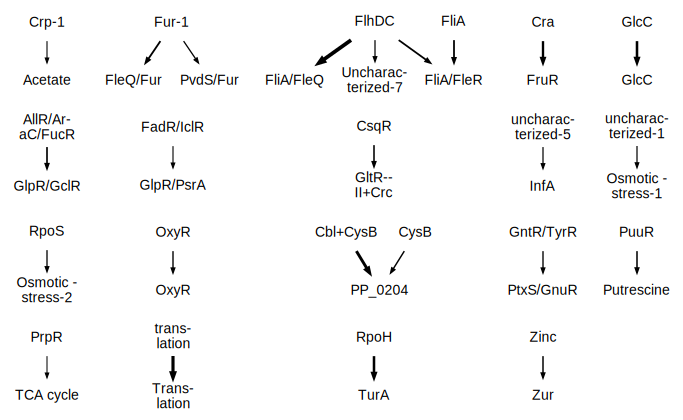

In [70]:
links

In [75]:
closest = {'PydR/OxyR','FnrA-2','FliA/FleR', 'TurA', 'PP_0204', 'GbdR/HmgR',
          'FnrA-1', 'PvdS/Fur', 'GlpR/PsrA', 'HmgR', 'ColR/CadR'}

In [76]:
M_closest = pd.DataFrame()

In [77]:
for i in closest:
    M_closest[i] = ica_data.M[i]

In [78]:
dots,links = compare_ica(ecoli_data.M, M_closest, cutoff=0.2,
                         ortho_file = '../example_data/eColi_full_protein_vs_pPutida_full_protein_parsed.csv')
dots

[('Cbl+CysB', 'PP_0204', 0.5880991683921883),
 ('RpoH', 'TurA', 0.506468201220273),
 ('Fur-1', 'PvdS/Fur', 0.25766059929616936),
 ('CysB', 'PP_0204', 0.2924329627317752),
 ('FliA', 'FliA/FleR', 0.35370610916682815),
 ('FadR/IclR', 'GlpR/PsrA', 0.22356704051794168),
 ('FlhDC', 'FliA/FleR', 0.35272332234882375)]

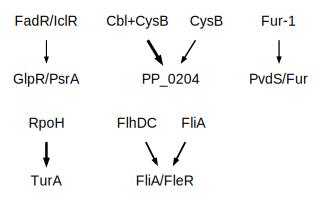

In [79]:
links

# E. coli Precise 2 comparison

In [48]:
ecoli_data2 = load_json_model('../../modulome_Ecoli/notebooks/precise2.json')

In [1]:
ica_data.M

NameError: name 'ica_data' is not defined

In [49]:
dots,links = compare_ica(ecoli_data2.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../example_data/eColi_full_protein_vs_pPutida_full_protein_parsed.csv')
dots

[('RcsC-related', 'Osmotic stress-1', 0.2782117575517065),
 ('GlcC', 'GlcC', 0.5670145638577818),
 ('OxyR', 'OxyR', 0.31467620835092625),
 ('CsqR', 'GltR-II+Crc', 0.3388317654690773),
 ('LldR+ArcA', 'LldR+Crc', 0.3014460671172437),
 ('PuuR', 'Putrescine', 0.3656578334529107),
 ('GntR', 'PtxS/GnuR', 0.3182731392685636),
 ('Translation', 'Translation', 0.7027603107915659),
 ('ZntR/Zur/CueR', 'Zur', 0.3093910969853989),
 ('Fur-1', 'PvdS/Fur', 0.26451880741084166),
 ('AllR/AraC/FucR', 'GlpR/GclR', 0.34454840064984243),
 ('Cra', 'FruR', 0.5241435889596944),
 ('Glyoxylate', 'PP_5350', 0.2929213015668861),
 ('Fe-related-2', 'FliA/FleQ/Fur', 0.2673558810422187),
 ('FliA', 'FliA/FleR', 0.3833164622690831),
 ('RpoH', 67, 0.5806774093766992),
 ('ppGpp', 'InfA', 0.29708820384249884),
 ('RpoS', 'Osmotic stress-2', 0.2863770547406412),
 ('CysB+Cbl', 58, 0.7043484553309879),
 ('FlhDC-2', 'FliA/FleR', 0.32236486434663),
 ('FlhDC-2', 'FliA/FleN/FleQ', 0.7932799046599949)]

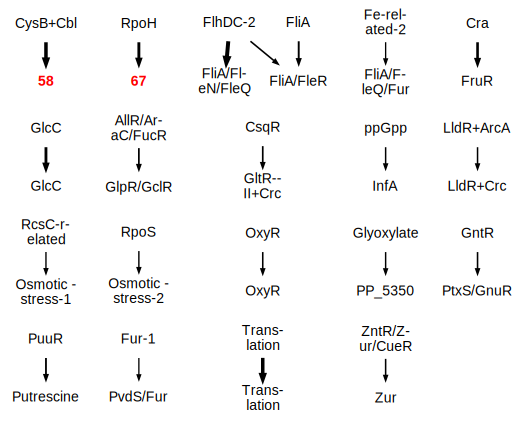

In [50]:
links

In [7]:
Paeru = load_json_model('../../modulome_Paeru/notebooks/Paeru_imod_info_113_updated.json')

In [9]:
dots,links = compare_ica(Paeru.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../Pputida_data_ICA3/bbh/pAeruginosa_full_protein_vs_pPutida_full_protein_parsed.csv')
dots

[('PhnR-1', 'Sulfur', 0.34486638271826164),
 ('RpoN', 'Osmotic stress-2', 0.4000366705501124),
 ('Translational', 'Translation', 0.7221685684010068),
 ('FleN-1', 'FleQ-1', 0.5307696141403312),
 ('LiuR', 'RbsR/LiuR/BkdR', 0.2805780870456355),
 ('NrtR-2', 'Multiple stress-1', 0.25889531755297474),
 ('NrtR-2', 'FnrA-2', 0.3337923917685126),
 ('CysB', 'PP_0204', 0.3514521862472921),
 ('Uncharacterized-2', 'Null-1', 0.26907794182192496),
 ('Uncharacterized-2', 'Uncharacterized-2', 0.3613640135256383),
 ('FleN-2', 'FliA/FleR', 0.41504208509463214),
 ('FruR', 'FruR', 0.40481865380739673),
 ('Uncharacterized-19', 'OxyR', 0.26629067318364524),
 ('PvdS-2', 'PvdS/Fur', 0.6763134188963076),
 ('Zur-1', 'FliA/FleQ/Fur', 0.25340976574393903),
 ('RpoS-1', 'BkdR', 0.29318458303886624),
 ('RpoS-1', 'TurB/PydR/OxyR', 0.2751062220969281),
 ('PtxS', 'PtxS/GnuR', 0.6066861579087502),
 ('HexR-2', 'GltR-II+Crc', 0.8019356141583688),
 ('NagQ', 'IonicLiquid', 0.2873458802460197),
 ('PhhR-2', 'HmgR', 0.389475807

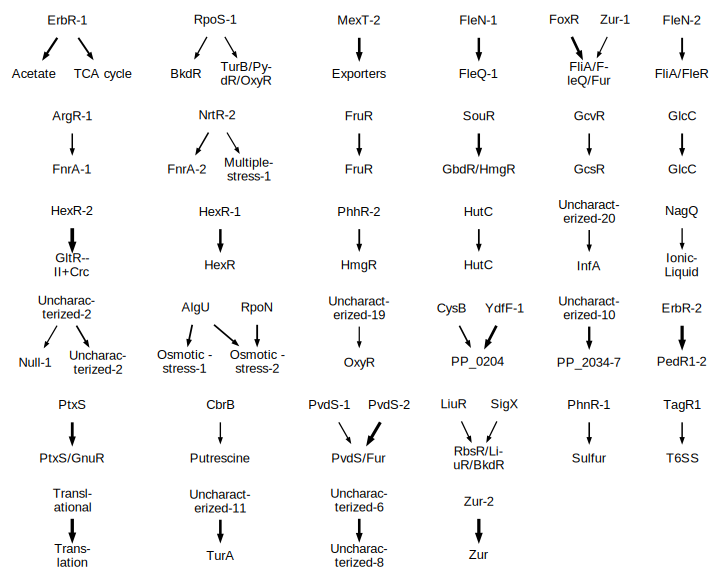

In [10]:
links

In [86]:
#from pymodulon import io
#io.save_to_json(ica_data, 'KT2440.json', compress = True)

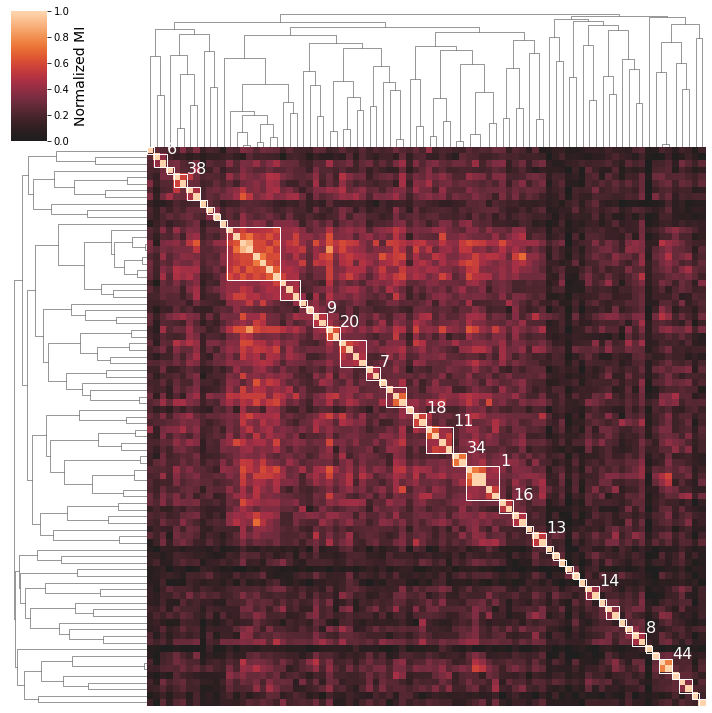

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.925, linkage='complete',
                         n_clusters=None)]

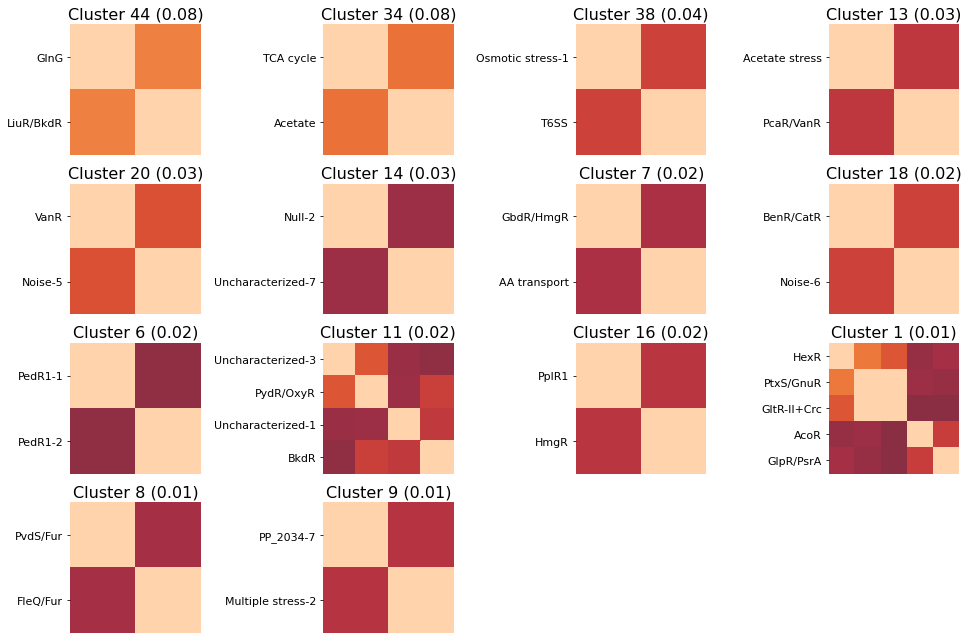

In [80]:
cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True)


<AxesSubplot:xlabel='PydR/OxyR iModulon Activity', ylabel='Uncharacterized-1 iModulon Activity'>

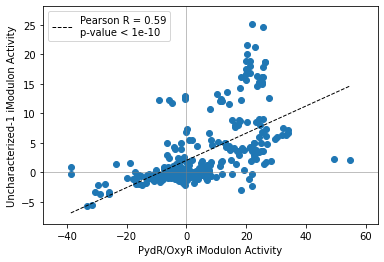

In [81]:
compare_activities(ica_data,'PydR/OxyR','Uncharacterized-1')

<AxesSubplot:xlabel='TurB/PydR/OxyR iModulon Activity', ylabel='InfA iModulon Activity'>

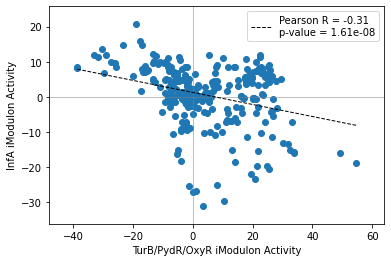

In [21]:
compare_activities(ica_data,'TurB/PydR/OxyR','InfA')

<AxesSubplot:xlabel='TurB/PydR/OxyR iModulon Activity', ylabel='Translation iModulon Activity'>

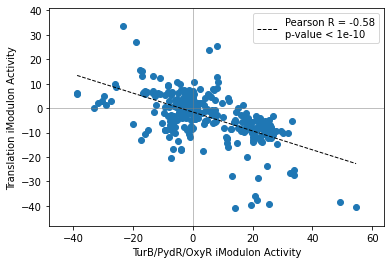

In [22]:
compare_activities(ica_data,'TurB/PydR/OxyR','Translation')

<AxesSubplot:xlabel='TurB/PydR/OxyR iModulon Activity', ylabel='TurA iModulon Activity'>

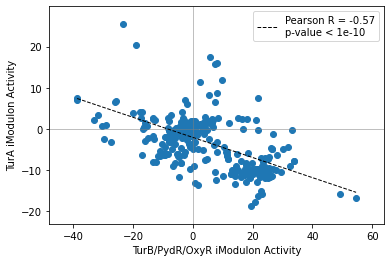

In [23]:
compare_activities(ica_data,'TurB/PydR/OxyR','TurA')

In [ ]:
compare_activities(ica_data,'GlnG','BkdR')

<AxesSubplot:xlabel='Uncharacterized-3 iModulon Activity', ylabel='BkdR iModulon Activity'>

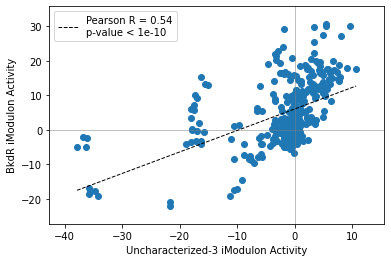

In [17]:
compare_activities(ica_data,'Uncharacterized-3','BkdR')

<AxesSubplot:xlabel='PplR1 iModulon Activity', ylabel='HmgR iModulon Activity'>

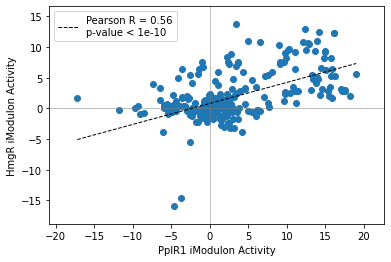

In [15]:
compare_activities(ica_data,'PplR1','HmgR')


<AxesSubplot:xlabel='PP_2034-7 iModulon Activity', ylabel='Multiple stress-2 iModulon Activity'>

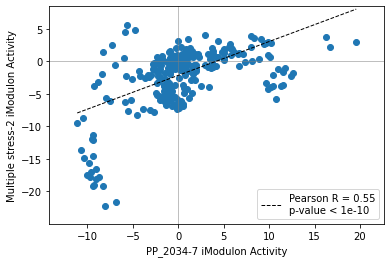

In [68]:
compare_activities(ica_data,'PP_2034-7','Multiple stress-2')


<AxesSubplot:xlabel='Osmotic stress-2 iModulon Activity', ylabel='T6SS iModulon Activity'>

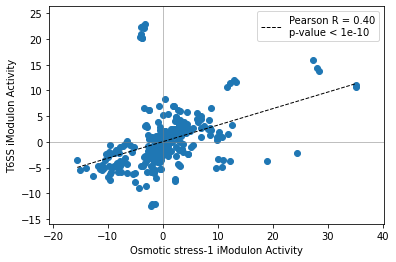

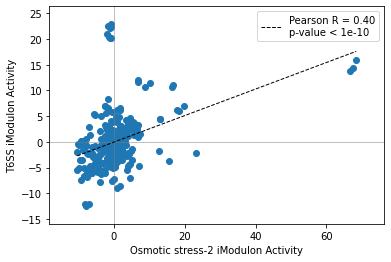

In [181]:
compare_activities(ica_data,'Osmotic stress-1','T6SS')
compare_activities(ica_data,'Osmotic stress-2','T6SS')

<AxesSubplot:xlabel='GlnG iModulon Activity', ylabel='RbsR/LiuR/BkdR iModulon Activity'>

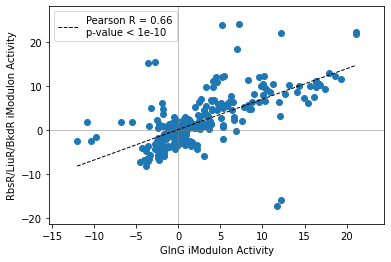

In [16]:
compare_activities(ica_data,'GlnG','RbsR/LiuR/BkdR')

<AxesSubplot:xlabel='GbdR/HmgR iModulon Activity', ylabel='AA transport iModulon Activity'>

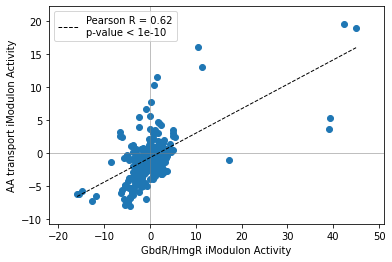

In [174]:
compare_activities(ica_data,'GbdR/HmgR','AA transport')

<AxesSubplot:xlabel='PplR1 iModulon Activity', ylabel='HmgR iModulon Activity'>

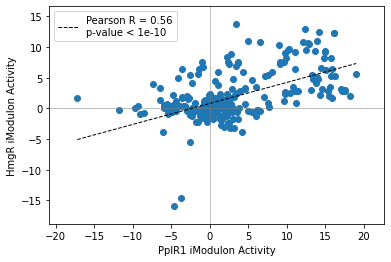

In [170]:
compare_activities(ica_data,'PplR1','HmgR')

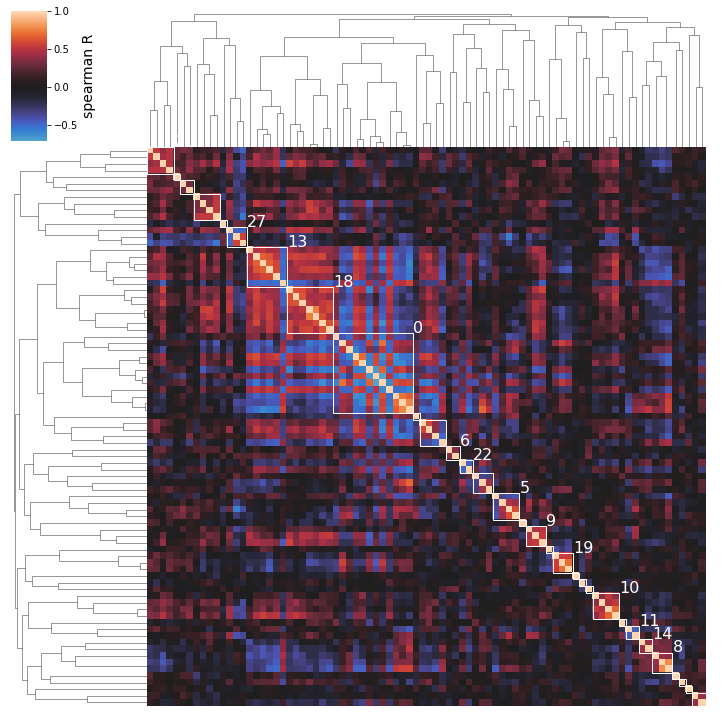

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.7, linkage='complete',
                         n_clusters=None)]

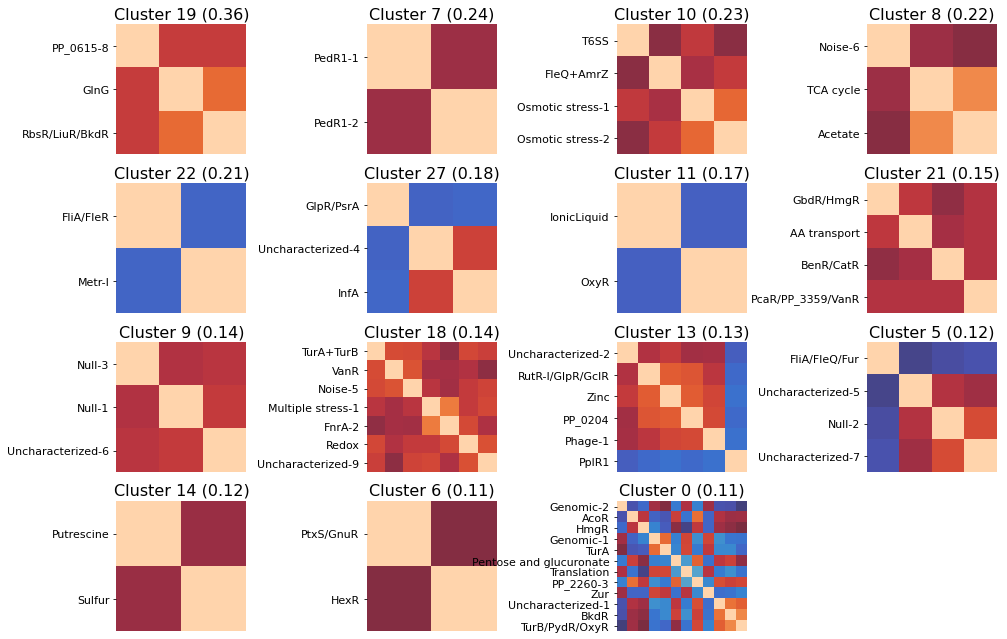

In [27]:
cluster_activities(ica_data, show_best_clusters=True, distance_threshold=0.7)

<AxesSubplot:xlabel='FliA iModulon Activity', ylabel='Metr-I iModulon Activity'>

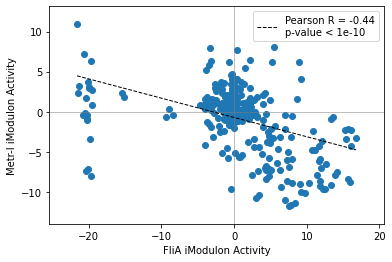

In [14]:
compare_activities(ica_data,'FliA','Metr-I')


<AxesSubplot:xlabel='PP_0615-8 iModulon Activity', ylabel='RbsR/LiuR/BkdR iModulon Activity'>

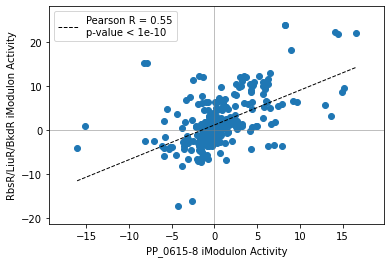

In [29]:
compare_activities(ica_data,'PP_0615-8','RbsR/LiuR/BkdR')


<AxesSubplot:xlabel='Zur iModulon Activity', ylabel='BkdR iModulon Activity'>

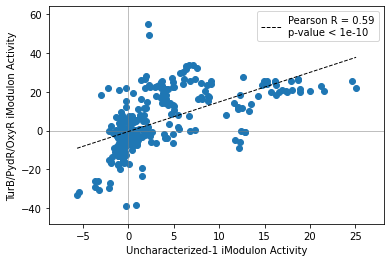

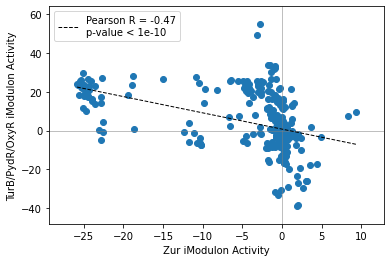

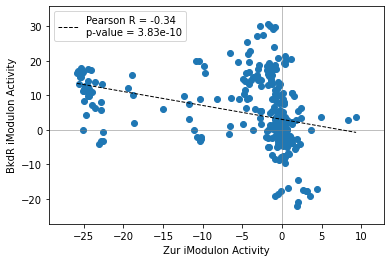

In [13]:
compare_activities(ica_data,'Uncharacterized-1','TurB/PydR/OxyR')
compare_activities(ica_data,'Zur','TurB/PydR/OxyR')
compare_activities(ica_data,'Zur','BkdR')


<AxesSubplot:xlabel='TurB/PydR/OxyR iModulon Activity', ylabel='BkdR iModulon Activity'>

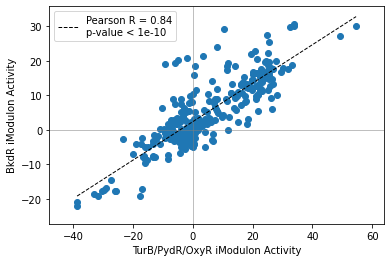

In [14]:
compare_activities(ica_data,'TurB/PydR/OxyR','BkdR')


<AxesSubplot:xlabel='GlnG iModulon Activity', ylabel='RbsR/LiuR/BkdR iModulon Activity'>

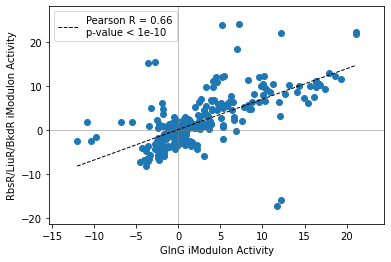

In [6]:
compare_activities(ica_data,'Osmo','RbsR/LiuR/BkdR')


<AxesSubplot:xlabel='FliA/FleR iModulon Activity', ylabel='Metr-I iModulon Activity'>

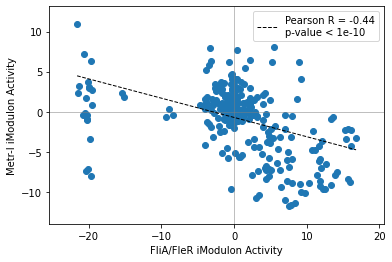

In [4]:
compare_activities(ica_data,'FliA/FleR','Metr-I')


<AxesSubplot:xlabel='Putrescine iModulon Activity', ylabel='Sulfur iModulon Activity'>

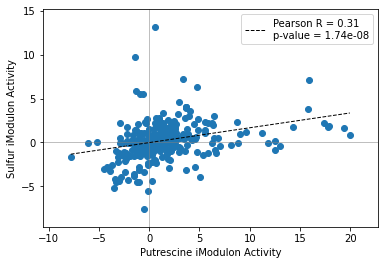

In [73]:
compare_activities(ica_data,'Putrescine','Sulfur')


<AxesSubplot:xlabel='59 iModulon Activity', ylabel='62 iModulon Activity'>

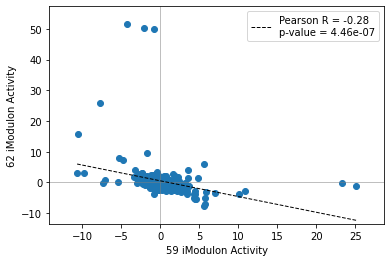

In [28]:
#compare_activities(ica_data,'IonicLiquid','OxyR')
compare_activities(ica_data,59,62)

<AxesSubplot:xlabel='GlpR/PsrA iModulon Activity', ylabel='LiuR/BkdR iModulon Activity'>

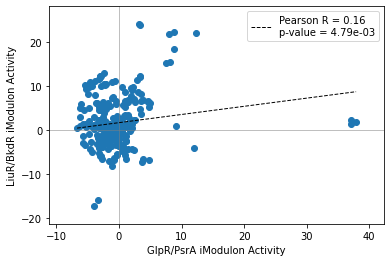

In [191]:
compare_activities(ica_data,'GlpR/PsrA','LiuR/BkdR')

<AxesSubplot:xlabel='FleQ+AmrZ iModulon Activity', ylabel='Osmotic stress-1 iModulon Activity'>

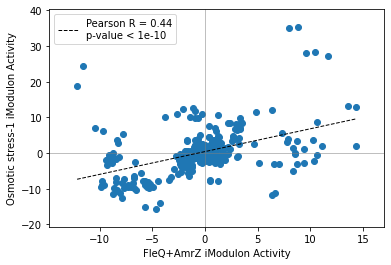

In [188]:
compare_activities(ica_data,'FleQ+AmrZ','Osmotic stress-1')

<AxesSubplot:xlabel='FleQ+AmrZ iModulon Activity', ylabel='Osmotic stress-2 iModulon Activity'>

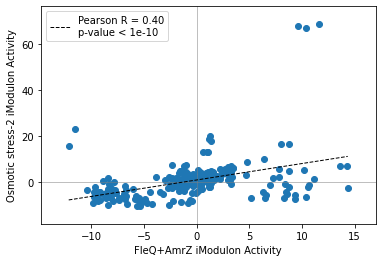

In [189]:
compare_activities(ica_data,'FleQ+AmrZ','Osmotic stress-2')

<AxesSubplot:xlabel='PydR/OxyR iModulon Activity', ylabel='Uncharacterized-1 iModulon Activity'>

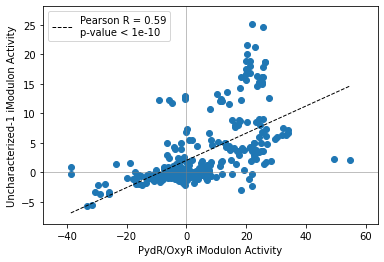

In [186]:
compare_activities(ica_data,'PydR/OxyR','Uncharacterized-1')

<AxesSubplot:xlabel='FliA/FleR iModulon Activity', ylabel='Metr-I iModulon Activity'>

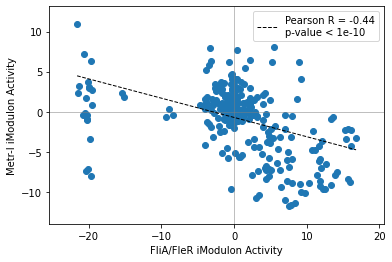

In [182]:
compare_activities(ica_data,'FliA/FleR','Metr-I')

AttributeError: 'set' object has no attribute 'items'

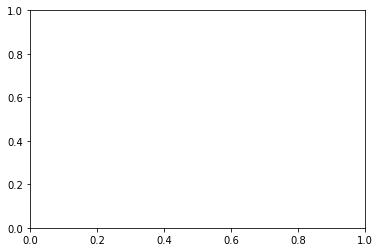

In [198]:
groups={'SBRG_ALE:XylALE_A1'}

compare_activities(ica_data,'Pyoverdine','FleQ-2',groups=groups)

<AxesSubplot:xlabel='Metr-I iModulon Activity', ylabel='FliA/FleR iModulon Activity'>

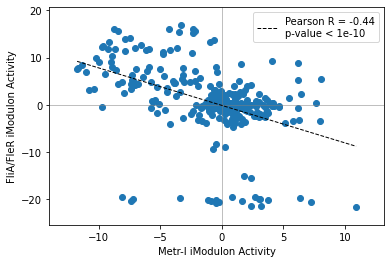

In [159]:
compare_activities(ica_data,'Metr-I','FliA/FleR')

<AxesSubplot:xlabel='GlnG iModulon Activity', ylabel='LiuR/BkdR iModulon Activity'>

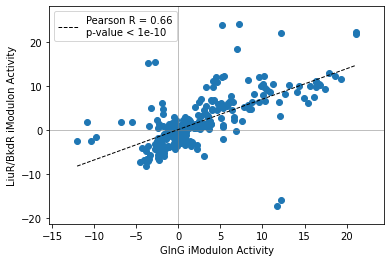

In [160]:
compare_activities(ica_data,'GlnG','LiuR/BkdR')

<AxesSubplot:xlabel='TCA cycle iModulon Activity', ylabel='Acetate iModulon Activity'>

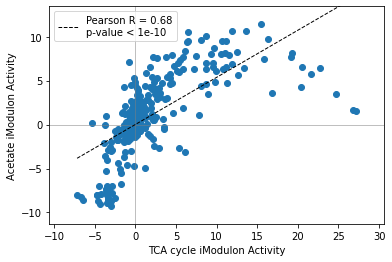

In [161]:
compare_activities(ica_data,'TCA cycle','Acetate')

<AxesSubplot:xlabel='Acetate stress iModulon Activity', ylabel='PP_0615-8 iModulon Activity'>

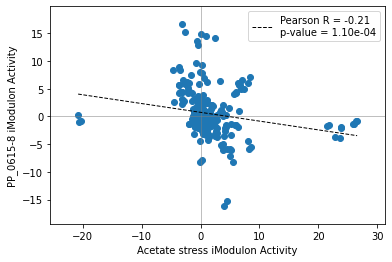

In [167]:
compare_activities(ica_data,'Acetate stress','PP_0615-8')

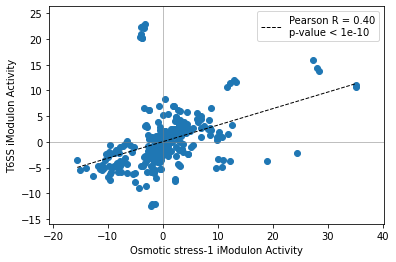

In [16]:
T6ss_1=compare_activities(ica_data,'Osmotic stress-1','T6SS')

In [17]:
T6ss_1.get_figure().savefig("T6SS1.svg")

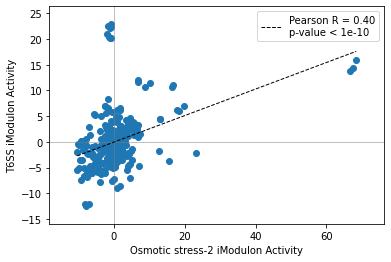

In [18]:
T6ss_2=compare_activities(ica_data,'Osmotic stress-2','T6SS')

In [19]:
T6ss_2.get_figure().savefig("T6SS2.svg")

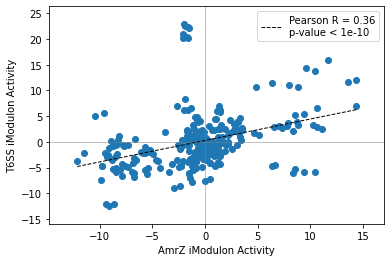

In [21]:
T6ss_3=compare_activities(ica_data,'AmrZ','T6SS')

In [22]:
T6ss_3.get_figure().savefig("T6SS3.svg")

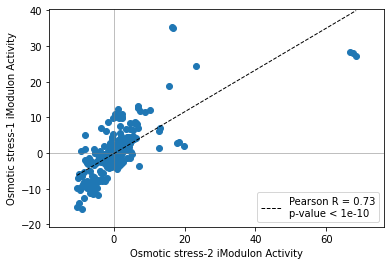

In [24]:
T6ss_4=compare_activities(ica_data,'Osmotic stress-2','Osmotic stress-1')

In [25]:
T6ss_4.get_figure().savefig("T6SS4.svg")

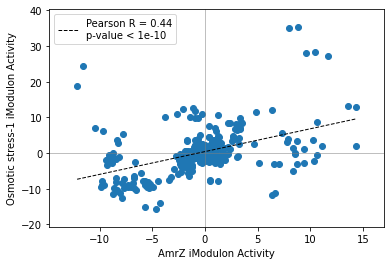

In [26]:
T6ss_5=compare_activities(ica_data,'AmrZ','Osmotic stress-1')
T6ss_5.get_figure().savefig("T6SS5.svg")

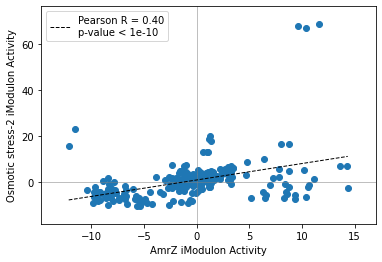

In [27]:
T6ss_6=compare_activities(ica_data,'AmrZ','Osmotic stress-2')
T6ss_6.get_figure().savefig("T6SS6.svg")

<AxesSubplot:xlabel='FleQ-2 iModulon Activity', ylabel='Uncharacterized-5 iModulon Activity'>

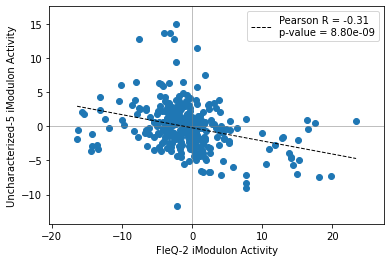

In [164]:
compare_activities(ica_data,'FleQ-2','Uncharacterized-5')

<AxesSubplot:xlabel='InfA iModulon Activity', ylabel='Uncharacterized-5 iModulon Activity'>

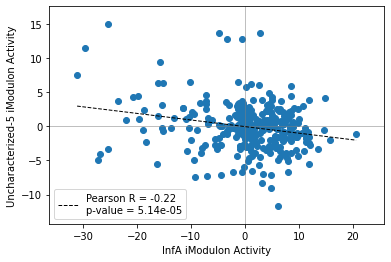

In [169]:
compare_activities(ica_data,'InfA','Uncharacterized-5')

In [ ]:
metadata_boxplot(ica_data,'GlnG')

In [ ]:
metadata_boxplot(ica_data,'LiuR/BkdR')

In [7]:
ica_data = load_json_model('../Pputida_data_ICA3/Pputida_ICA3.json')

In [ ]:
view_acitiv

# Gene numbers in iModulons

In [89]:
#Answering to how many genes are captured as iModulon members

mylist = []
for k in ica_data.imodulon_names:
        mylist.append(ica_data.view_imodulon(k).index.to_list())

In [90]:
mylist=sum(mylist,[])
mylist = list(dict.fromkeys(mylist))
len(mylist)

1258

In [91]:
len(ica_data.gene_table.index)

5564

In [92]:
len(mylist)/len(ica_data.gene_table.index)*100

22.60963335729691